# Vorhersage der Gesundheit von Bienenvölkern auf Basis von Audiodaten

Konstantin Haupt (902425), Janne Wernecken (XXXXXX)  
Audio Data Science, Sommersemester 2024 – Hochschule Düsseldorf  
Prof. Dr. Jochen Steffens, Prof. Dr. Florian Huber

## Inhaltsverzeichnis

1. Abstract
2. Einleitung
3. Datensatz & Vorverarbeitung
4. ML-Modell
5. Ergebnisse
6. Diskussion
7. Aussicht
8. Literatur

## 1. Abstract

TODO

## 2. Einleitung

TODO

## 3. Datensatz & Vorverarbeitung

TEXT

In [ ]:
## All required library imports for further analysis ##

import os
import sklearn
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import librosa
from IPython.core.display import SVG
from IPython.display import Audio
import sys
sys.path.append("D:\\Software-Projekte\\Uni\\ds_audio\\src\\")
import config

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [ ]:
## All required project-specific imports for further analysis ##

import features as ft

### Exploration und Vorverarbeitung der Metadaten

TEXT

In [ ]:
metadata_df = pd.read_csv(config.METADATA_FILE)
metadata_df.head()

,sample_name,label
0,Hive3_28_07_2017_QueenBee____23_50_00,active
1,Hive1 12_06_2018_QueenBee____00_00_00,active
2,Hive1 12_06_2018_QueenBee____00_10_00,active
3,Hive1 12_06_2018_QueenBee____00_20_00,active
4,Hive1 12_06_2018_QueenBee____00_30_00,active


In [ ]:
# Preprocess metadata by extracting hive number from sample name & encoding target feature
ft.preprocess_metadata()

In [ ]:
metadata_column_names = ['sample_name', "label", "hive number"]

metadata_processed = np.load(config.PROCESSED_METADATA_FILE, allow_pickle=True)
metadata_processed_df = pd.DataFrame(metadata_processed, columns=metadata_column_names)

metadata_processed_df = metadata_processed_df.astype({'hive number': 'int32'})
metadata_processed_df = metadata_processed_df.astype({'label': 'int32'})
metadata_processed_df.head()

,sample_name,label,hive number
0,Hive3_28_07_2017_QueenBee____23_50_00,0,3
1,Hive1 12_06_2018_QueenBee____00_00_00,0,1
2,Hive1 12_06_2018_QueenBee____00_10_00,0,1
3,Hive1 12_06_2018_QueenBee____00_20_00,0,1
4,Hive1 12_06_2018_QueenBee____00_30_00,0,1


In [ ]:
metadata_processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573 entries, 0 to 572
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   sample_name  573 non-null    object
 1   label        573 non-null    int32 
 2   hive number  573 non-null    int32 
dtypes: int32(2), object(1)
memory usage: 9.1+ KB


In [ ]:
metadata_processed_df.describe()

,label,hive number
count,573.000000,573.000000
mean,0.497382,2.005236
std,0.500430,1.000860
min,0.000000,1.000000
25%,0.000000,1.000000
50%,0.000000,3.000000
75%,1.000000,3.000000
max,1.000000,3.000000


<Axes: title={'center': 'Verteilung der Datenpunkte nach Anwesenheit einer Bienenkönigin'}>

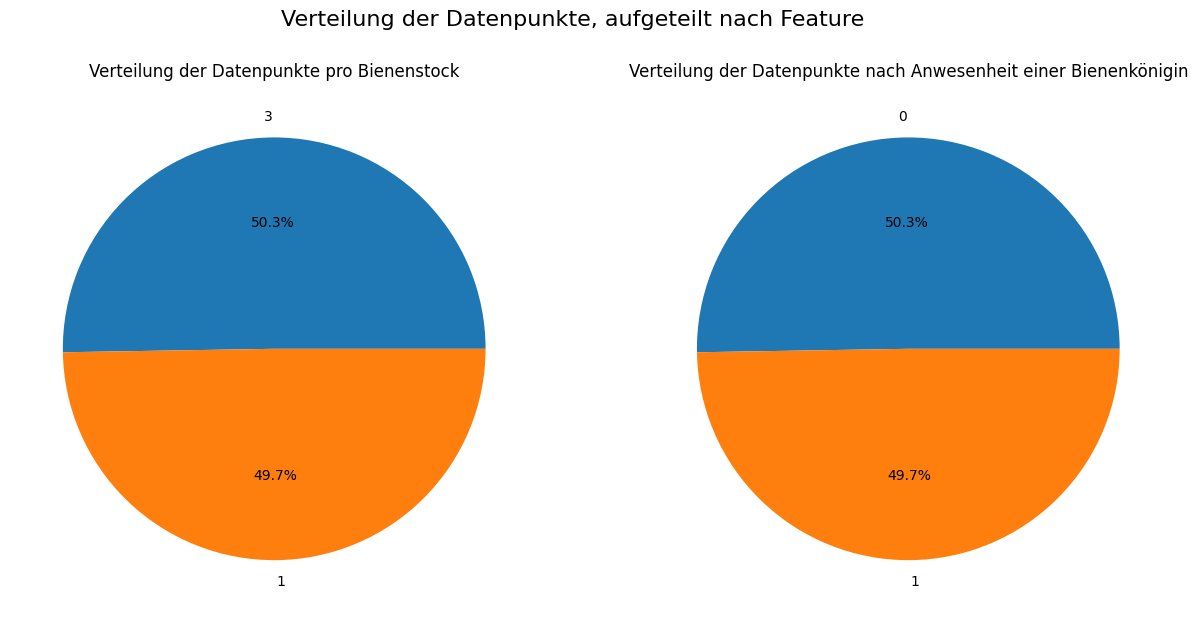

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle("Verteilung der Datenpunkte, aufgeteilt nach Feature", fontsize=16)

metadata_processed_df.value_counts("hive number").plot.pie(title="Verteilung der Datenpunkte pro Bienenstock", ax=ax[0], ylabel='', autopct='%1.1f%%')
metadata_processed_df.value_counts("label").plot.pie(title="Verteilung der Datenpunkte nach Anwesenheit einer Bienenkönigin", ax=ax[1], ylabel='', autopct='%1.1f%%')

<Axes: title={'center': 'Anteil der Datenpunkte mit Anwesenheit einer Bienenkönigin \n Bienenstock 3'}>

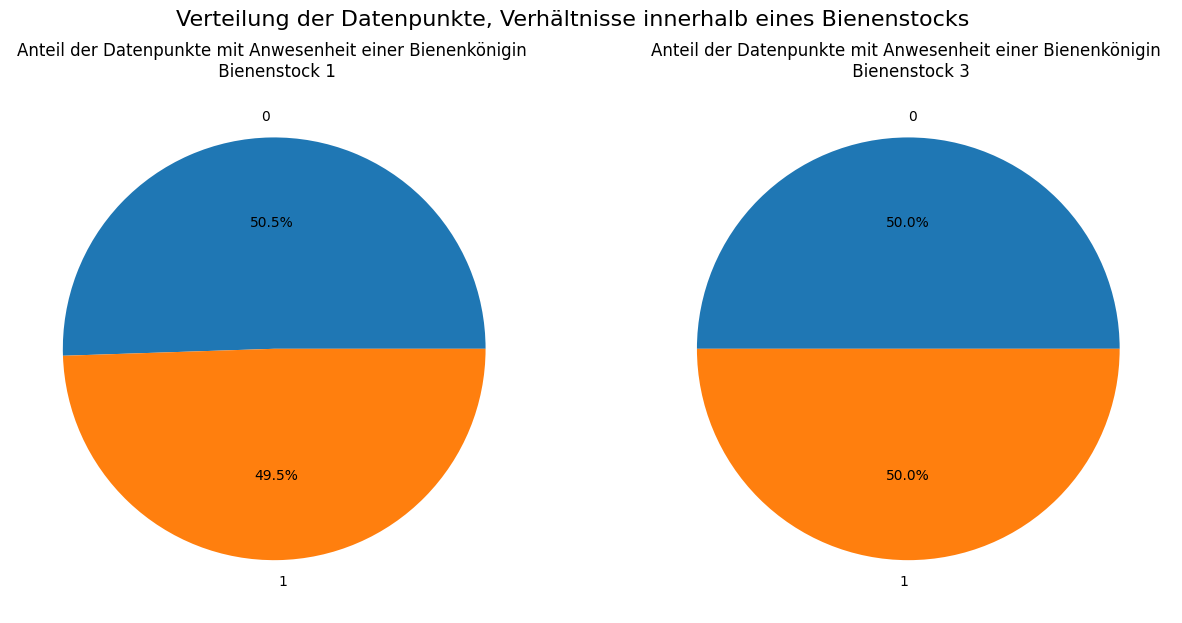

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle("Verteilung der Datenpunkte, Verhältnisse innerhalb eines Bienenstocks", fontsize=16)

metadata_processed_df[metadata_processed_df["hive number"] == 1].value_counts("label").plot.pie(title="Anteil der Datenpunkte mit Anwesenheit einer Bienenkönigin \n Bienenstock 1", ax=ax[0], ylabel='', autopct='%1.1f%%')
metadata_processed_df[metadata_processed_df["hive number"] == 3].value_counts("label").plot.pie(title="Anteil der Datenpunkte mit Anwesenheit einer Bienenkönigin \n Bienenstock 3", ax=ax[1], ylabel='', autopct='%1.1f%%')

### Vorverarbeitung der Audiodaten

TEXT + Codesnippet zu Segmentierung(?)

In [ ]:
ft.preprocess_data_and_pack_to_npy()
ft.segment_metadata()

### Exploration der Audiodaten

TEXT

In [ ]:
# Select samples for each combination of hive and queen status
mask_hive_1_queen = (metadata_processed_df["hive number"] == 1) & (metadata_processed_df["label"] == 1)
mask_hive_1_no_queen = (metadata_processed_df["hive number"] == 1) & (metadata_processed_df["label"] == 0)
mask_hive_3_queen = (metadata_processed_df["hive number"] == 3) & (metadata_processed_df["label"] == 1)
mask_hive_3_no_queen = (metadata_processed_df["hive number"] == 3) & (metadata_processed_df["label"] == 0)

sample_names = ["Bienenvolk 1 mit Bienenkönigin", "Bienenvolk 1 ohne Bienenkönigin", "Bienenvolk 3 mit Bienenkönigin", "Bienenvolk 3 ohne Bienenkönigin"]

masks = [mask_hive_1_queen, mask_hive_1_no_queen, mask_hive_3_queen, mask_hive_3_no_queen]
selected_samples = []

for mask in masks:
    sample = metadata_processed_df[mask].iloc[0]
    selected_samples.append(sample)

In [ ]:
# Collect audio files for selected samples
sample_audio_files_path = librosa.util.find_files(config.RAW_DATA_PATH)
sample_audio_files = []

for sample in selected_samples:
    audio_time_series, sample_rate = librosa.load(os.path.join(config.RAW_DATA_PATH, sample["sample_name"] + ".wav"), sr=config.sampling_rate)
    sample_audio_files.append({'y': audio_time_series, 'sr': sample_rate})

In [ ]:
# Output audios for selected samples
for i, audio_file in enumerate(sample_audio_files):
  print(sample_names[i])
  audio_player = Audio(data=audio_file['y'], rate=audio_file['sr'])
  display(audio_player)

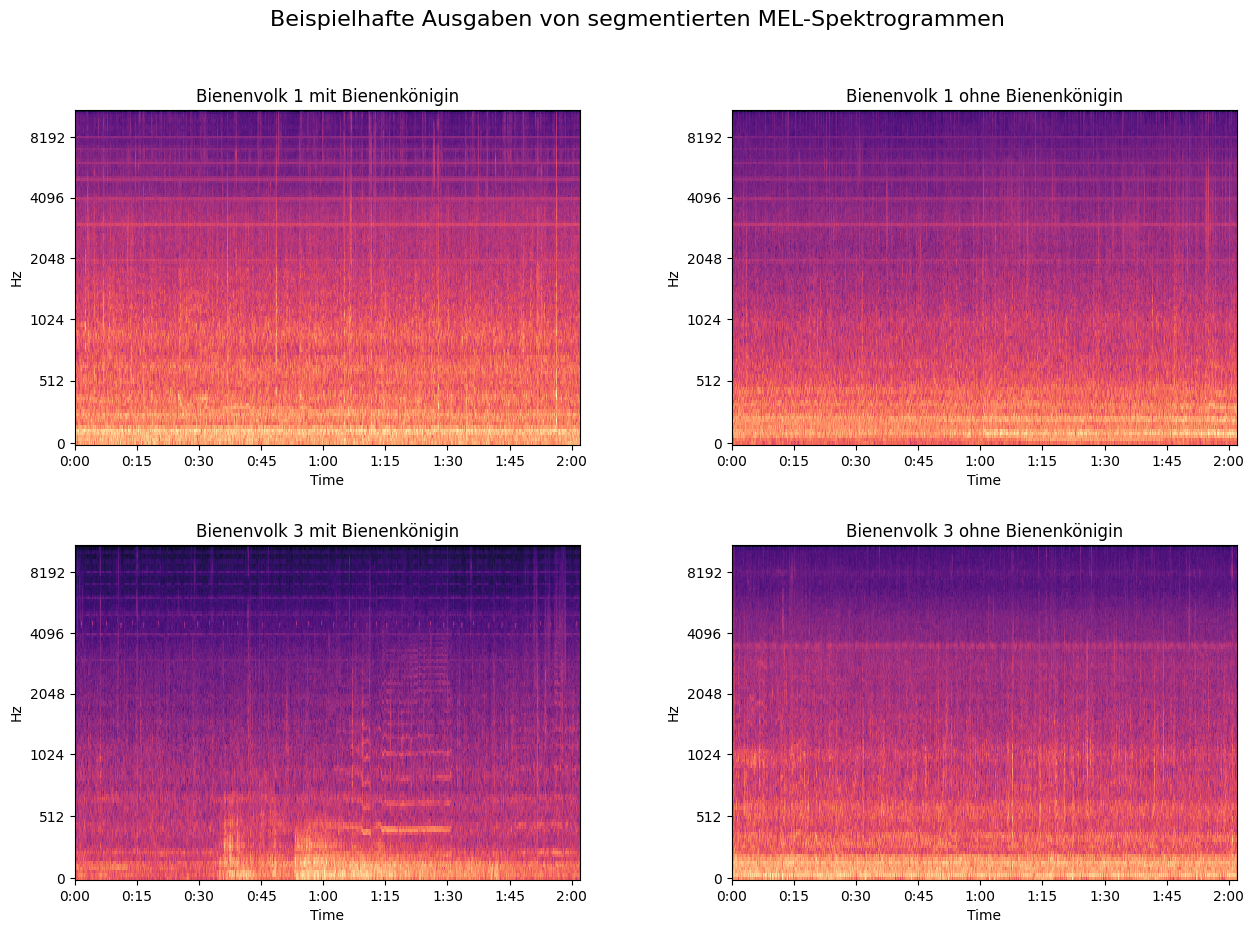

In [ ]:
# Plot selected samples
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Beispielhafte Ausgaben von segmentierten MEL-Spektrogrammen", fontsize=16)
fig.subplots_adjust(wspace = 0.3, hspace=0.3)

for i in range(0, len(selected_samples)):
    melsp = np.load(os.path.join(config.NORMALIZED_MEL_SPEC_PATH, selected_samples[i]["sample_name"] + "__segment0.npy"), allow_pickle=True)
    librosa.display.specshow(melsp, x_axis='time', y_axis='mel', ax=axs[i//2, i%2], sr=config.sampling_rate, hop_length=config.hop_length)
    axs[i//2, i%2].set_title(sample_names[i])

## 4. ML-Modell

TODO

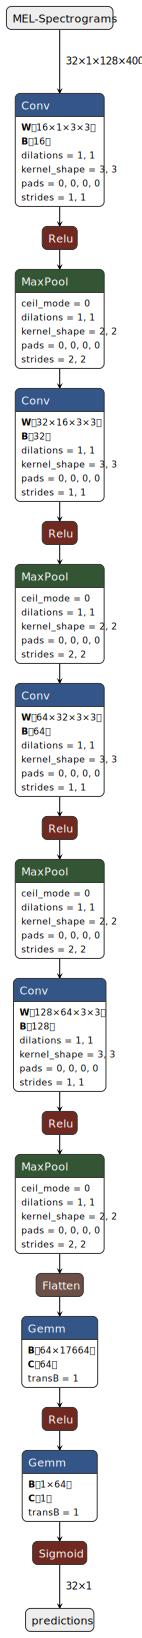

In [1]:
SVG(filename='..\\src\\assets\\model_20240920_161533_0_CNN.svg')

## 5. Ergebnisse

TODO

## 6. Diskussion

TODO

## 7. Aussicht

TODO

## 8. Literatur

TODO